In [1]:
!sudo pip3 install seaborn

    100% |████████████████████████████████| 163kB 5.4MB/s eta 0:00:01
  Running setup.py bdist_wheel for seaborn ... - done
  Stored in directory: /root/.cache/pip/wheels/cb/c8/67/83d615c0ef9b529558525aa521025b183de8c5b156799b091e
Successfully built seaborn


# Setup
The first part of the notebook is used to setup the libraries, import the data and familiarize myself with some basic questions about the data:
- format
- Total people
- how many, men, women
- general age statistics

After I have this information I will hopefully be able to ask better questions. 

##### Skip to the Questions seciton if you don't want to see the setup and inital data exploration.

In [2]:
#import important python Libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# pull in the raw data and make sure in formatted correctly
# the code for this is based on the example found here:http://matplotlib.org/examples/pylab_examples/barchart_demo.html

titanic_data = pd.read_csv('titanic-data.csv')
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Basic Information about the data

In [4]:
print("There are {} passengers records in the dataset, {} of which survived giving a survival rate of {:.0%}".format(len(titanic_data),titanic_data['Survived'].sum(), titanic_data['Survived'].mean()))
print(titanic_data.groupby('Sex').size())
print(titanic_data.groupby(['Sex','Survived']).size())

print("for records with valid ages:")
valid_age_data = titanic_data[titanic_data['Age'].notnull()]
valid_age_data['Age'].describe()


There are 891 passengers records in the dataset, 342 of which survived giving a survival rate of 38%
Sex
female    314
male      577
dtype: int64
Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
dtype: int64
for records with valid ages:


count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

/usr/lib64/python3.4/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


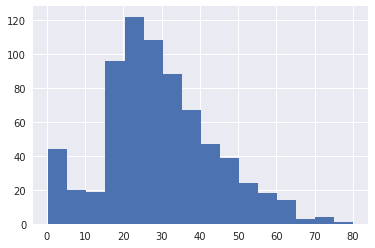

In [5]:
valid_age_data['Age'].hist(bins=16)

In [6]:
titanic_data.groupby('Embarked').size()

Embarked
C    168
Q     77
S    644
dtype: int64

In [7]:
titanic_data.groupby('Pclass').size()

Pclass
1    216
2    184
3    491
dtype: int64

In [8]:
titanic_data['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

/usr/lib64/python3.4/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


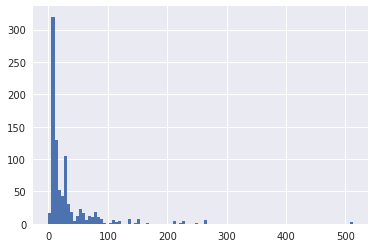

In [9]:
titanic_data['Fare'].hist(bins=100)

## Data Manipulation 

I need to do some clean up and categorization.
Since I will want to combine Fare, and age with other categorical data I will:
- convert age to 5 year increments (or unknown)
- convert fare to \$10 increments up to \$100 then \$100 to \$300 and over \$300

In [10]:

#####For the age calculation I will remove the nan values then do the corrcoef calculation
data = titanic_data  # Create a new var before I change it.
data_age = data[data['Age'].notnull()]
### a diction for storing the list of columns when i convert the categorial data
category_columns = {}

In [11]:

## Categorize age in 5 year increments
#### it's difficult to use a list comprehision or function here because of the nan values... so I'm goin to use a for loop
age_cat = []
for a in data['Age']:
    if np.isnan(a):
        age_cat.append('unknown')
    else:
        num =int((a//5) * 5)
        age_cat.append('age{}to{}'.format(num, num + 5))
        
age_tmp = pd.get_dummies(age_cat)
category_columns["Age"] = age_tmp.columns.values
data = pd.concat([data,age_tmp], axis=1)

fare_cat = []
for a in data['Fare']:
    if np.isnan(a):
        fare_cat.append('unknown')
    elif a >= 200:
        fare_cat.append('Fare200+')
    else:
        num =int((a//10) * 10)
        fare_cat.append('fare{}to{}'.format(num, num + 10))
fare_tmp = pd.get_dummies(fare_cat)
category_columns['Fare'] = fare_tmp.columns.values
data = pd.concat([data,fare_tmp], axis=1)


In [12]:
#modify the DataFrame to create a set of categorical columns out of colums using he pandas get dummies funcitons
#should not be used with age
for col in ["Pclass","Sex","SibSp","Parch","Embarked"]:
    data = pd.concat([data,pd.get_dummies(titanic_data[col], prefix=col)], axis=1)
    category_columns[col] = ["{}_{}".format(col,c) for c in data[col].unique()]




In [13]:
data[data['Sex_female'] ==1]['Survived'].mean()

0.7420382165605095

#### category_columns
The category_columns dictionary is used to hold groupings of categories to make it easier to pass them to the caluclate_stats function



In [14]:
category_columns

{'Age': array(['age0to5', 'age10to15', 'age15to20', 'age20to25', 'age25to30',
        'age30to35', 'age35to40', 'age40to45', 'age45to50', 'age50to55',
        'age55to60', 'age5to10', 'age60to65', 'age65to70', 'age70to75',
        'age80to85', 'unknown'], dtype=object),
 'Embarked': ['Embarked_S', 'Embarked_C', 'Embarked_Q', 'Embarked_nan'],
 'Fare': array(['Fare200+', 'fare0to10', 'fare100to110', 'fare10to20',
        'fare110to120', 'fare120to130', 'fare130to140', 'fare140to150',
        'fare150to160', 'fare160to170', 'fare20to30', 'fare30to40',
        'fare40to50', 'fare50to60', 'fare60to70', 'fare70to80',
        'fare80to90', 'fare90to100'], dtype=object),
 'Parch': ['Parch_0',
  'Parch_1',
  'Parch_2',
  'Parch_5',
  'Parch_3',
  'Parch_4',
  'Parch_6'],
 'Pclass': ['Pclass_3', 'Pclass_1', 'Pclass_2'],
 'Sex': ['Sex_male', 'Sex_female'],
 'SibSp': ['SibSp_1',
  'SibSp_0',
  'SibSp_3',
  'SibSp_4',
  'SibSp_2',
  'SibSp_5',
  'SibSp_8']}

In [15]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'age0to5', 'age10to15',
       'age15to20', 'age20to25', 'age25to30', 'age30to35', 'age35to40',
       'age40to45', 'age45to50', 'age50to55', 'age55to60', 'age5to10',
       'age60to65', 'age65to70', 'age70to75', 'age80to85', 'unknown',
       'Fare200+', 'fare0to10', 'fare100to110', 'fare10to20', 'fare110to120',
       'fare120to130', 'fare130to140', 'fare140to150', 'fare150to160',
       'fare160to170', 'fare20to30', 'fare30to40', 'fare40to50', 'fare50to60',
       'fare60to70', 'fare70to80', 'fare80to90', 'fare90to100', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'SibSp_0', 'SibSp_1',
       'SibSp_2', 'SibSp_3', 'SibSp_4', 'SibSp_5', 'SibSp_8', 'Parch_0',
       'Parch_1', 'Parch_2', 'Parch_3', 'Parch_4', 'Parch_5', 'Parch_6',
       'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

#### create_column_union
so that I can easily handle different combination of demographic data the create_column_union function will take 2 columns and generate a new set of columns for unique combination of values with 1 in in the row if the passenger falls matches that combination. for example  females from 30 to 35 in passenger class 2 would be represented with 1 in a column named age30to35&Sex_female&Pclass_2. which is created by combining Sex and Pclass into GenderPclass and then GenderPclass and Age. This will be done below

####  calculate_stat and calculate_stats functions
The calculate_stat and function takes the data and a column name and return a dataframe with count and survival percent for that rows that have a 1 in it for that column. In other words if a passenger falls into the demographic represented by the column as discribed above they are counted/summarized.

calculate_stats calls calculate_stat on each column passed and concats the output

In [16]:
####Function to take a list of categories, combine them and find the survial rate and corrilation 
def calculate_stat(data, column):

    stat = pd.DataFrame(index = [column], columns = ["Count", "Survival Rate"])
    if column in data.columns:
        tmp = data[data[column] == 1]
        stat["Count"] = len(tmp)
        stat["Survival Rate"] = tmp["Survived"].mean()
    else:
        stat['Count'] = 0
        stat['Survival Rate'] = 0
    #return only groups that have at least one person who fell into it
    return stat[stat['Count'] >0]


def calculate_stats(data, cols):
    return pd.concat([calculate_stat(data, col) for col in cols]).sort_values("Survival Rate", ascending=False)
# This function will take 2 list of columns and create a new pandas array with the value 1 if the passenger has 1 in both columns
# this is used to combine categorical data like age and gender
def create_column_union(data, column_group1, column_group2):
    # create a list of the combined column names
    new_columns = pd.DataFrame()
    new_column_names = []
    for col1 in column_group1:
        for col2 in column_group2:
            tmp_col_name = "{}&{}".format(col1,col2)
            if not tmp_col_name in data.columns:
                new_columns[tmp_col_name] = np.bitwise_and(data[col1], data[col2])
                new_column_names.append(tmp_col_name)           
    return new_columns, new_column_names


##### Now that I have a handy way of creating new groupings of passenger based on the data I can finally get to my questions

# Questions

The most obvious line of questions is around the survial rate of different demographics represented in the dataset, and this is the aspect of the data that I will be exploring. 

### Question 1: What were the demographic with the highest and lowest survial rates?

Answer this I am going to use the function I created above to categorize the passenger by Gender,PClass and Age, this should be broken down far enough to see some really high survival rates and really low survival rates. 


In [17]:
new_data, names = create_column_union(data, category_columns["Sex"], category_columns["Pclass"])
category_columns["PclassGender"] = names
data = pd.concat([data,new_data], axis=1)
new_data, names = create_column_union(data, category_columns["Age"], category_columns["PclassGender"])
category_columns["PclassGenderAge"] = names
data = pd.concat([data,new_data], axis=1)


In [18]:
pclass_gender_age = calculate_stats(data, category_columns['PclassGenderAge'])
pclass_gender_age

,Count,Survival Rate
unknown&Sex_female&Pclass_2,2,1.000000
age15to20&Sex_female&Pclass_1,12,1.000000
age0to5&Sex_male&Pclass_1,2,1.000000
age40to45&Sex_female&Pclass_1,7,1.000000
age30to35&Sex_female&Pclass_2,12,1.000000
age30to35&Sex_female&Pclass_1,11,1.000000
age45to50&Sex_female&Pclass_1,6,1.000000
age45to50&Sex_female&Pclass_2,3,1.000000
age50to55&Sex_female&Pclass_2,4,1.000000
age55to60&Sex_female&Pclass_1,4,1.000000


### Question 1 - Thoughts
After combining the PClass, Gender and Age I can see that I have gone to far even before I create any visuals. If I only consider groups that have 10 or more members There are multiple groups that have a 100% survival rate as well as a 0% survival rate. I am going to look add the data little more generally and see what I find. 

In [19]:
pclass_gender_age[pclass_gender_age['Count'] >= 10]

,Count,Survival Rate
age15to20&Sex_female&Pclass_1,12,1.000000
age30to35&Sex_female&Pclass_2,12,1.000000
age30to35&Sex_female&Pclass_1,11,1.000000
age20to25&Sex_female&Pclass_1,13,1.000000
age35to40&Sex_female&Pclass_1,16,1.000000
age20to25&Sex_female&Pclass_2,11,0.909091
age25to30&Sex_female&Pclass_2,14,0.857143
age0to5&Sex_female&Pclass_3,12,0.666667
age25to30&Sex_male&Pclass_1,13,0.615385
age15to20&Sex_female&Pclass_3,18,0.611111


In [20]:
pclass_gender = calculate_stats(data, category_columns["PclassGender"])
pclass_gender

,Count,Survival Rate
Sex_female&Pclass_1,94,0.968085
Sex_female&Pclass_2,76,0.921053
Sex_female&Pclass_3,144,0.500000
Sex_male&Pclass_1,122,0.368852
Sex_male&Pclass_2,108,0.157407
Sex_male&Pclass_3,347,0.135447


/usr/lib64/python3.4/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


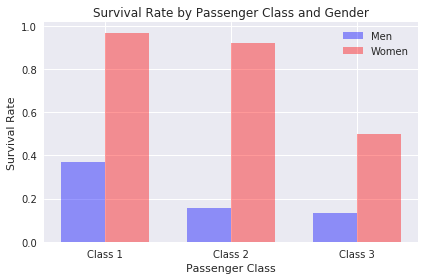

In [21]:
#create a nice bar chart to compare
menpclass = pclass_gender[3:6]['Survival Rate'].tolist()
womenpclass = pclass_gender[:3]['Survival Rate'].tolist()
fig, ax = plt.subplots()

index = np.arange(3)
bar_width = 0.35

opacity = 0.4
rects1 = plt.bar(index, menpclass, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Men')

rects2 = plt.bar(index + bar_width, womenpclass, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Women')

plt.xlabel('Passenger Class')
plt.ylabel('Survival Rate')
plt.title('Survival Rate by Passenger Class and Gender')
plt.xticks(index + bar_width / 2, ('Class 1', 'Class 2', 'Class 3'))
plt.legend()

plt.tight_layout()
plt.show()



In [22]:
# This matches what I found in the exploration section, but let me recap
gender = calculate_stats(data, category_columns["Sex"])
gender

,Count,Survival Rate
Sex_female,314,0.742038
Sex_male,577,0.188908


/usr/lib64/python3.4/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


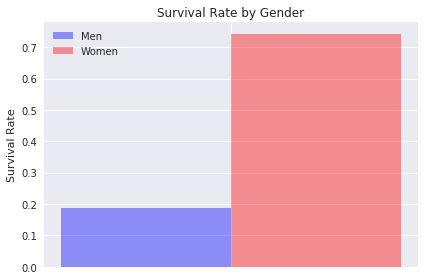

In [23]:
women = gender[0:1]['Survival Rate'].tolist()
men = gender[1:]['Survival Rate'].tolist()
gender
fig, ax = plt.subplots()

index = np.arange(1)
bar_width = 0.35

opacity = 0.4
rects1 = plt.bar(index, men, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Men')

rects2 = plt.bar(index + bar_width, women, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Women')

plt.ylabel('Survival Rate')
plt.title('Survival Rate by Gender')
plt.xticks(index + bar_width / 2, (''))
plt.legend()

plt.tight_layout()
plt.show()

### Significant???
These 2 bar charts clearly show that there is a significantly higher survival rate for females regardless of there class, right? Because these are binomial distributions lets check statistically using a 2 poportion z-test. 
references: http://stats.stackexchange.com/questions/113602/test-if-two-binomial-distributions-are-statistically-different-from-each-other and http://en.wikipedia.org/wiki/Statistical_hypothesis_testing

using the following 2 formulas to calculate a z score
$$ \hat{p} = \frac{n_1\hat{p}_1+n_2\hat{p}_2}{n_1+n_2} $$

$$ z=\frac{\hat{p}_1 - \hat{p}_2}{\sqrt{\hat{p}(1 - \hat{p})(\frac{1}{n_1} + \frac{1}{n_2})}} $$


#### Class 1 

$$ \hat{p} = \frac{94\cdot0.968085 + 122\cdot0.368852}{94+122} $$


$$ \hat{p} = 0.629629324 $$


$$ z = \frac{0.968085 - 0.368852}{\sqrt{0.629629324(1 - 0.629629324)(1/94 + 1/122)}} $$

$$ z = 9.04181 $$

This z-score is huge and verifies the statistical significance of the difference between the death rate for men and women.


#### Class 2

$$ \hat{p} = \frac{76\cdot0.921053 + 108\cdot0.157407}{76+108} $$


$$ \hat{p} = 0.472826 $$


$$ z = \frac{0.921053 - 0.157407}{\sqrt{0.472826(1 - 0.472826)(1/76 + 1/108)}} $$

$$ z = 10.21587 $$

Again, this is a huge z-score


#### Class 3
	144	0.500000
    347	0.135447
$$ \hat{p} = \frac{144\cdot0.500000 + 347\cdot0.135447}{144+347} $$


$$ \hat{p} = 0.24236 $$


$$ z = \frac{0.500000 - 0.135447}{\sqrt{0.24236(1 - 0.24236)(1/144 + 1/347)}} $$

$$ z = 8.58234 $$

Again, this is a huge z-score

### Question 2 Is there a relationship between the embark port and survial rate for men.
I am only looking at men for this question because I already know that women has a significantly higher survial rate them men and I have a feeling that there is going to be a significant difference between the group of men. 

In [25]:
#taking out "Embarked_nan" because there are no values
new_data, names = create_column_union(data, category_columns["Sex"], category_columns["Embarked"][:3])
category_columns["GenderEmbarked"] = names
data = pd.concat([data,new_data], axis=1)


In [26]:
male_embarck = calculate_stats(data, category_columns["GenderEmbarked"])[3:]
male_embarck

,Count,Survival Rate
Sex_male&Embarked_C,95,0.305263
Sex_male&Embarked_S,441,0.174603
Sex_male&Embarked_Q,41,0.073171
